In [1]:
import tensorflow.keras as keras
import tensorflow as tf
tf.__version__

'2.18.0'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import os
import zipfile

local_zip = '/tmp/image_scene.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/image_scene')
zip_ref.close()

In [5]:
base_dir = '/tmp/image_scene'

#train directories
train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir = os.path.join(base_dir, 'seg_test/seg_test')

In [6]:
import shutil

# create directories for partial train and test data (200 images/category)

categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
num_images = 200
partial_train_dir = '/tmp/partial_train'
partial_test_dir = '/tmp/partial_test'

os.makedirs(partial_train_dir, exist_ok=True)
os.makedirs(partial_test_dir, exist_ok=True)

In [7]:
# copy 200 images from each category to 'partial...' directives
def reduce_data(input_dir, output_dir):
  for category in categories:
    category_dir = os.path.join(input_dir, category)
    output_category_dir = os.path.join(output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    image_files = os.listdir(category_dir)[:num_images]
    for image_file in image_files:
      source_path = os.path.join(category_dir, image_file)
      dst_path = os.path.join(output_category_dir, image_file)
      shutil.copy(source_path, dst_path)

reduce_data(train_dir, partial_train_dir)
reduce_data(test_dir, partial_test_dir)

In [8]:
# initilaizing arrays
train_images = []
train_labels = []

In [9]:
import numpy as np

# combining all sub paths in 'partial...' directives into one for each set (training, test)
# so that later we can use flow_from_dataframe
def combining_paths(input_dir, features_array, labels_array):
  for category in categories:
    category_dir = os.path.join(input_dir, category)
    for fname in os.listdir(category_dir):
      features_array.append(os.path.join(category_dir, fname))
      labels_array.append(category)

combining_paths(partial_train_dir, train_images, train_labels)

In [11]:
# convert all arrays to numpy arrays (dataframe) of images
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augment train data to reduce overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# do not augment val and test data!
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
from keras import models
from keras import layers
from keras import optimizers
from sklearn.model_selection import KFold
import pandas as pd

k=4
num_epochs = 30
batch_size = 35
kf = KFold(n_splits=k, shuffle=True, random_state=42)

all_scores=[]

train_acc = []
val_acc =  []
train_loss = []
val_loss = []

In [14]:
history = None #manually resets history
for fold, (train_idx, val_idx) in enumerate(kf.split(train_images)):
  print(f'\nProcessing fold # {fold+1}/{k}  ############################')

  # split data
  train_x, val_x = train_images[train_idx], train_images[val_idx]
  train_y, val_y = train_labels[train_idx], train_labels[val_idx]

  train_generator = None
  val_generator = None

  i = 0
  j = 0


  # preprocess data
  train_generator = train_datagen.flow_from_dataframe(
    dataframe = pd.DataFrame({'filename': train_x, 'class': train_y}),
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size= batch_size,
    class_mode='categorical',
    shuffle=True
  )

  # val generator
  val_generator = val_datagen.flow_from_dataframe(
      dataframe=pd.DataFrame({'filename': val_x, 'class': val_y}),
      x_col='filename',
      y_col='class',
      target_size=(150, 150),
      batch_size= batch_size,
      class_mode='categorical',
      shuffle=True)

  # extract feature maps - training
  for inputs_batch, labels_batch in train_generator:
    features_batch = conv_base.predict(inputs_batch)
    if i == 0:
        train_x_extract = np.zeros((len(train_x),) + features_batch.shape[1:])
        train_y_label = np.zeros((len(train_x), labels_batch.shape[1]))
    train_x_extract[i * batch_size : (i + 1) * batch_size] = features_batch
    train_y_label[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= len(train_x):
      break

  # extract feature maps - validation
  for inputs_batch, labels_batch in val_generator:
    features_batch = conv_base.predict(inputs_batch)
    if j == 0:
        val_features = np.zeros((len(val_x),) + features_batch.shape[1:])
        val_labels = np.zeros((len(val_x), labels_batch.shape[1]))
    val_features[j * batch_size : (j + 1) * batch_size] = features_batch
    val_labels[j * batch_size : (j + 1) * batch_size] = labels_batch
    j += 1
    if j * batch_size >= len(val_x):
      break

  model = models.Sequential()
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(256, activation='relu', input_dim= 4 * 4 * 512))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(6, activation='softmax'))

  model.compile(optimizer=optimizers.Adam(learning_rate=2e-4),
                loss = 'categorical_crossentropy',
                metrics=['acc'])

  history = model.fit(train_x_extract, train_y_label,
                      epochs=num_epochs,
                      batch_size = batch_size,
                      validation_data=(val_features, val_labels))

  train_acc.append(history.history['acc'])
  val_acc.append(history.history['val_acc'])
  train_loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



Processing fold # 1/4  ############################
Found 900 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
2/2 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - acc: 0.2276 - loss: 2.1931 - val_acc: 0.6400 - val_loss: 1.0076
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.5051 - loss: 1.1944 - val_acc: 0.7067 - val_loss: 0.8178
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6089 - loss: 0.9824 - val_acc: 0.7233 - val_loss: 0.7162
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6844 - loss: 0.8093 - val_acc: 0.7567 - val_loss: 0.6317
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7050 - loss: 0.7632 - val_acc: 0.7833 - val_loss: 0.5905
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6954 - loss: 0.7255 - val_acc: 0.7667 - val_loss: 0.5920
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7488 - loss: 0.6309 - val_acc: 0.7967 - val_loss: 0.5423
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7590 - loss: 0.5678 - val_acc: 0.7867 - val_loss: 0.5360
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8110 - loss: 0.5018 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - acc: 0.2522 - loss: 2.1442 - val_acc: 0.6500 - val_loss: 1.0858
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.4882 - loss: 1.3005 - val_acc: 0.6400 - val_loss: 0.9219
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6148 - loss: 0.9883 - val_acc: 0.6600 - val_loss: 0.8481
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6684 - loss: 0.8854 - val_acc: 0.7000 - val_loss: 0.7446
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7096 - loss: 0.7186 - val_acc: 0.7267 - val_loss: 0.7088
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7434 - loss: 0.6655 - val_acc: 0.7833 - val_loss: 0.6250
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7890 - loss: 0.5653 - val_acc: 0.7667 - val_loss: 0.6150
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7626 - loss: 0.6003 - val_acc: 0.7867 - val_loss: 0.5942
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7939 - loss: 0.5370 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.2623 - loss: 2.1907 - val_acc: 0.6767 - val_loss: 1.0758
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.4960 - loss: 1.2673 - val_acc: 0.6900 - val_loss: 0.8823
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6060 - loss: 0.9706 - val_acc: 0.7333 - val_loss: 0.7576
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.6622 - loss: 0.8839 - val_acc: 0.7267 - val_loss: 0.7443
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.6741 - loss: 0.8417 - val_acc: 0.7567 - val_loss: 0.6797
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7469 - loss: 0.6450 - val_acc: 0.7567 - val_loss: 0.6882
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7668 - loss: 0.6448 - val_acc: 0.7433 - val_loss: 0.6675
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7697 - loss: 0.6095 - val_acc: 0.7600 - val_loss: 0.6505
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7900 - loss: 0.5492 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - acc: 0.2141 - loss: 2.1392 - val_acc: 0.6200 - val_loss: 1.1303
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4894 - loss: 1.2689 - val_acc: 0.7100 - val_loss: 0.8487
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5814 - loss: 1.0400 - val_acc: 0.7333 - val_loss: 0.7191
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.6499 - loss: 0.9003 - val_acc: 0.7567 - val_loss: 0.6305
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7228 - loss: 0.7811 - val_acc: 0.7700 - val_loss: 0.5904
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7196 - loss: 0.7522 - val_acc: 0.7567 - val_loss: 0.6047
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7147 - loss: 0.7392 - val_acc: 0.7933 - val_loss: 0.5543
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7751 - loss: 0.6017 - val_acc: 0.7633 - val_loss: 0.5714
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7830 - loss: 0.6003 - v

In [15]:
# extract test features and labels
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count, 6))
  generator = test_datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical')
  i = 0

  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size > sample_count:
      # Note that since generators yield data indefinitely in a loop,
      # we must `break` after every image has been seen once.
      break
  return features, labels

test_features, test_y = extract_features(partial_test_dir, 1200)

Found 1200 images belonging to 6 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━

In [16]:
# quick check
print(len(train_acc))
print(len(val_acc))
print(len(train_loss))
print(len(val_loss))

4
4
4
4


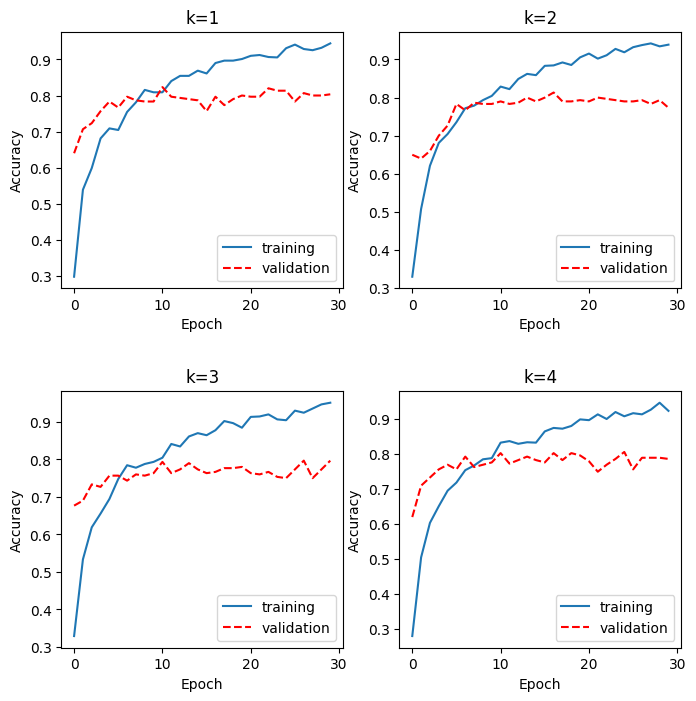

In [17]:
import matplotlib.pyplot as plt

# Cross fold 0
fig, dummys = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4)
dummys[0, 0].plot(np.arange(num_epochs), train_acc[0], label='training')
dummys[0, 0].plot(np.arange(num_epochs), val_acc[0], 'r--', label='validation')
dummys[0, 0].set_title("k=1")
dummys[0, 0].set(xlabel='Epoch', ylabel='Accuracy')
dummys[0, 0].legend()

# Cross fold 1
dummys[0, 1].plot(np.arange(num_epochs), train_acc[1], label='training')
dummys[0, 1].plot(np.arange(num_epochs), val_acc[1], 'r--', label='validation')
dummys[0, 1].set_title("k=2")
dummys[0, 1].set(xlabel='Epoch', ylabel='Accuracy')
dummys[0, 1].legend()

# Cross fold 2
dummys[1, 0].plot(np.arange(num_epochs), train_acc[2], label='training')
dummys[1, 0].plot(np.arange(num_epochs), val_acc[2], 'r--', label='validation')
dummys[1, 0].set_title("k=3")
dummys[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
dummys[1, 0].legend()

# Cross fold 3
dummys[1, 1].plot(np.arange(num_epochs), train_acc[3], label='training')
dummys[1, 1].plot(np.arange(num_epochs), val_acc[3], 'r--', label='validation')
dummys[1, 1].set_title("k=4")
dummys[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
dummys[1, 1].legend()
plt.show()


In [18]:
model.save('Hw2.3.h5')

In [19]:
test_loss, test_acc = model.evaluate(test_features, test_y, verbose=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8354 - loss: 0.5264


In [20]:
test_generator = test_datagen.flow_from_directory(
    partial_test_dir,
    target_size=(150, 150),
    batch_size= 35,
    class_mode='categorical')

Found 1200 images belonging to 6 classes.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


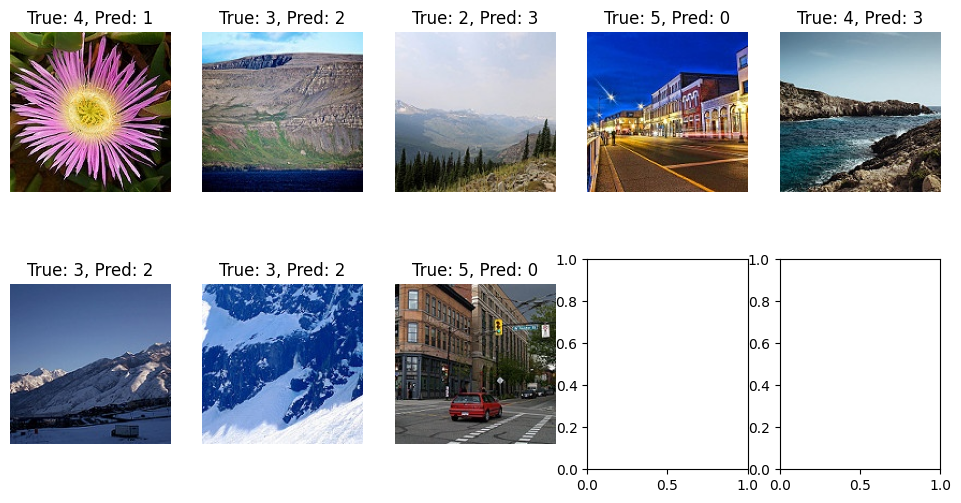

In [21]:
# Get predictions on validation set
test_images, test_labels = next(test_generator)  # Get a batch

#extract features
test_features = conv_base.predict(test_images)

#predictions
predictions = model.predict(test_features)
predicted_labels = np.argmdummy(predictions, dummyis=1)
true_classes = np.argmdummy(test_labels, dummyis=1)

# Identify misclassified samples
misclassified_indices = np.where(predicted_labels != true_classes)[0]

# Display a few misclassified images
fig, dummyes = plt.subplots(2, 5, figsize=(12, 6))
for i, idx in enumerate(misclassified_indices[:10]):
    dummyes[i // 5, i % 5].imshow(test_images[idx])
    dummyes[i // 5, i % 5].set_title(f'True: {true_classes[idx]}, Pred: {predicted_labels[idx]}')
    dummyes[i // 5, i % 5].dummyis('off')

plt.show()


block1_conv1


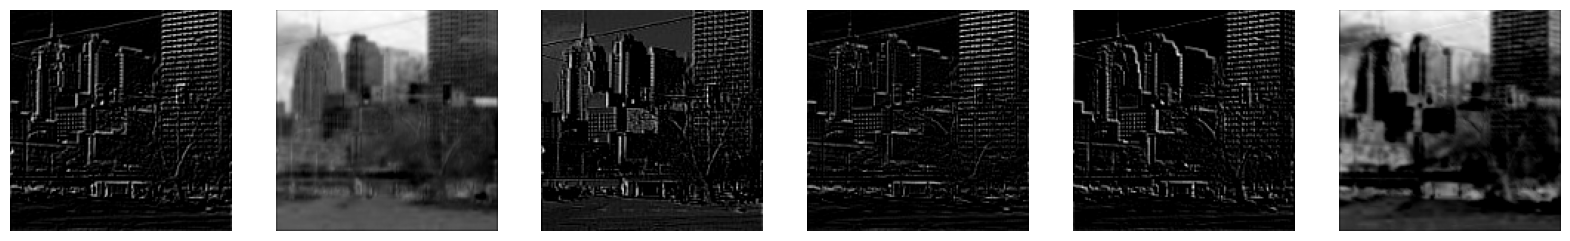

block3_conv1


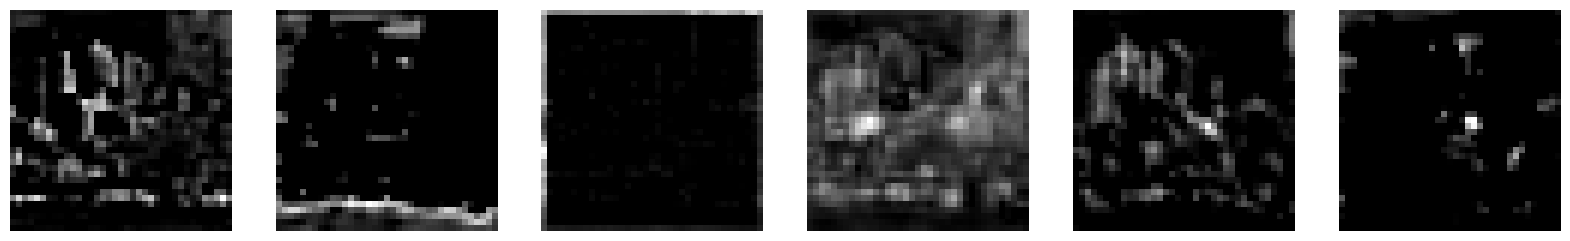

block5_conv1


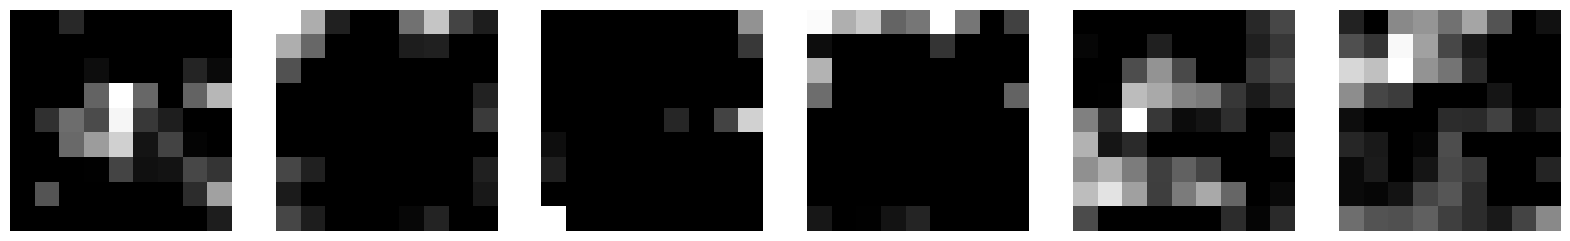

In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def view_conv_filters(model, layer_name, size=150, filters=6):
    # Load and preprocess the image
    img_path = '/tmp/partial_test/buildings/20060.jpg'
    img = image.load_img(img_path, target_size=(size, size))
    image = image.img_to_array(img)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extract features from each given layer
    layer = model.get_layer(layer_name)
    features_extracted = tf.keras.Model(inputs=model.input, outputs=layer.output)
    activations = features_extracted(image)

    # The first 6 from each layer will be plot
    fig, axes = plt.subplots(1, filters, figsize=(20, 5))
    for i in range(filters):
        dummy = axes[i]
        dummy.imshow(activations[0, :, :, i], cmap='gray')
        dummy.axis("off")
    plt.show()

# The first 6 filter activation for the image at each level
print('block1_conv1')
view_conv_filters(conv_base, 'block1_conv1')
print('block3_conv1')
view_conv_filters(conv_base, 'block3_conv1')
print('block5_conv1')
view_conv_filters(conv_base, 'block5_conv1')